In [4]:
import time
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import xgboost as xg 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split



'''TrainingSet'''
DataSet_A=pd.read_csv('TrainingSet_0.csv').iloc[:,2:]
DataSet_B=pd.read_csv("TrainingSet_new.csv").iloc[:,2:]
DataSet_A.rename({'GB':'level'},axis=1,inplace=True)
DataSet_B.rename({'GB':'level'},axis=1,inplace=True)


'''TestingSet'''
TestingSet=pd.read_csv("TestingSet_0.csv").iloc[:,2:]
TestingSet.rename({'GB':'level'},axis=1,inplace=True)

X_test=TestingSet.iloc[:,:-1].values
Y_test=TestingSet.iloc[:,-1].values


OS_1=pd.read_csv('TrainingSet_new.csv').iloc[:,1:]

OS_2=pd.read_csv('OS.csv').iloc[:,1:]

Data=pd.concat([OS_1,OS_2])

T2_X=Data.iloc[:,1:-1].values
T2_Y=Data.iloc[:,-1:].values

## For Data Setting 4~6

T2_X_2=OS_1.iloc[:,1:-1].values
T2_Y_2=OS_1.iloc[:,-1:].values

## For Data Setting 10~12

Negatives=OS_1[OS_1.GB==0].iloc[:,1:]

D_10=pd.read_csv("DataSetting_10.csv").iloc[:,1:]
D_10=D_10[D_10.GB==1]
Test_10=pd.concat([Negatives,D_10])
Test_10.to_csv('Test_10.csv')

D_11=pd.read_csv("DataSetting_11.csv").iloc[:,1:]
D_11=D_11[D_11.GB==1]
Test_11=pd.concat([Negatives,D_11])
Test_11.to_csv('Test_11.csv')

D_12=pd.read_csv("DataSetting_12.csv").iloc[:,1:]
D_12=D_12[D_12.GB==1]
Test_12=pd.concat([Negatives,D_12])
Test_12.to_csv('Test_12.csv')

##將每個種類放入字典中
D=pd.read_csv('Bad_Types.csv').iloc[:,1:]
Bad_Types={D.cb[i]:i for i in range (len(D))}

In [5]:
'''二元資料集的平衡程度'''
def Balance_Ratio(TrainingSet):
    r=len(TrainingSet[TrainingSet.level==1])/len(TrainingSet[TrainingSet.level==0])
    return r

'''新的 TrainingSet '''
def training(TrainingSet):
    
    global X_train, Y_train
    
    X_train=TrainingSet.iloc[:,:-1].values
    Y_train=TrainingSet.iloc[:,-1].values
    
'''Classifier''' 

## 矩陣 左下: 真正陽性 未被找到 , 右下: 真正陽性 且 被找到  / infor=0 代表只顯示被預測出的 BAD 類型
def cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=0):

    global Y,Bad,check,I,ar
    check=0
    
    #XG = XGBClassifier(n_estimators=n_E,learning_rate=LR,random_state=r)
    XG = XGBClassifier(n_estimators=100,learning_rate=0.7,random_state=r)
    XG_fit = XG.fit(X_train,Y_train)
    Y_score=XG.predict(X_test)
    Y_score=pd.DataFrame(Y_score)
    Y_true=pd.DataFrame(Y_test)
    Y=pd.concat([Y_true,Y_score],axis=1)
    Y.columns=["class_true","class_pd"]
    s = range(2)
    I = np.zeros([2,2])
    
    for i,x in zip(s,range(2)):
        for j,y in zip(s,range(2)):
            I[x,y]=len(Y[(Y.class_true==i)&(Y.class_pd==j)])
    
    num_pd=0
    for i in range(2):
        num_pd=num_pd+I[i,-1]

    if num_pd!=0:
        precision=I[-1,-1]/num_pd
    else:
        precision=0
    
    if sum(I[-1])!=0:
        recall=I[-1,-1]/sum(I[-1])
    else:
        recall=0
    
    I=I.astype(int)
    
    
    #if (I[0][1]+I[1][1])!=0:

    #    if Balance_Ratio(TestingSet)<I[1][1]/I[0][1]:
    #        print('OK!')
    #        check=1
    #    else: print('BAD!')
            
    #print(I,'\n')
    
    if infor==0:
        
        ar=(I[0][1]+I[1][1])/len(Y_test)
        #print('Aging_Rate:',ar)
        
        TP=Y[(Y.class_true==1)&(Y.class_pd==1)].index
        Bad=[]
        for j in range(len(TP)):

            Index=TP[j]
            Key=X_test[Index]
            Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
            Bad=np.append(Bad,Bad_Types[Key[0]])
            Bad.sort()
            
        print('Types of Bad :',Bad)   
    
    elif infor==1:
        FN=Y[(Y.class_true==1)&(Y.class_pd==0)].index
        Bad_miss=[]
        for j in range(len(FN)):

            Index=FN[j]
            Key=X_test[Index]
            Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
            Bad_miss=np.append(Bad_miss,Bad_Types[Key[0]])
            Bad_miss.sort()
        
        print('Types of Bad not found:',Bad_miss)
        
    #print("Precision,Recall:",precision,',',recall,'\n')
        
    return precision, recall


   
## 可以更改 Beta 值    
def F_score(P,R,beta=1):
    if (P!=0)&(R!=0):
        f=((1+beta*beta)*(P*R))/((beta*beta*P)+R)
    else: f=0
    return f 

## 可以決定是否運算 train_score
def CLF_result(DataSetting,train_score_show=1,J=0,balance_show=0):
    
    global PR_sub,Hard,Count_sub
    PR_sub=[]
    Count_sub=[]
    
    if balance_show==1:
        print('Balance ratio:',Balance_Ratio(DataSetting),'\n')
    training(DataSetting)
    if train_score_show==1:
        
        #print('Train_1 :')
        P,R=cf_matrix(X_train,X_train,Y_train,Y_train,r=0,infor=2)
        PR_sub=np.append(PR_sub,(P,R))
        GT_0=I[0][0]+I[0][1]
        Train_OK=GT_0
        FP=I[0][1]
        Train_NG=I[1][0]+I[1][1]
        #print('Trained_OK:',Train_OK)
        #print('Trained_NG:',Train_NG)
        
        #print('Train_2 :')
        
        if J<=3:
            P,R=cf_matrix(X_train,T2_X,Y_train,T2_Y,r=0,infor=2)
        elif J<=6:
            P,R=cf_matrix(X_train,T2_X_2,Y_train,T2_Y_2,r=0,infor=2)
        elif J<=9:
            P,R=cf_matrix(X_train,T2_X,Y_train,T2_Y,r=0,infor=2)
        elif J<=12:
            Test=pd.read_csv("Test_%s.csv" %J).iloc[:,1:]
            Test_X=Test.iloc[:,:-1].values
            Test_Y=Test.iloc[:,-1:].values
            P,R=cf_matrix(X_train,Test_X,Y_train,Test_Y,r=0,infor=2)
            
        PR_sub=np.append(PR_sub,(P,R))
        GT_0_2=I[0][0]+I[0][1]
        FP_2=I[0][1]
        Hard=(FP_2-FP)/(GT_0_2-GT_0)
        Filt_OK=GT_0_2-GT_0
        #print('Filtered_OK',Filt_OK)
        #print("Hardness:",Hard)
        
    
    #print('Test : ')
   
    P,R=cf_matrix(X_train,X_test,Y_train,Y_test,r=0)
    PR_sub=np.append(PR_sub,(P,R))
    #PR_sub=np.around(PR_sub, decimals=3)
    Aging_rate=sum(I[:,1])/sum(sum(I))
    Count_sub=np.append(Count_sub,(Train_OK,Train_NG,Filt_OK,Aging_rate))
    
    
    #F=F_score(P,R,beta=3)*100
    
    #print('F_score:',F,'%')

## 先建一個 BAD名稱為 cols 的 df 
def compare_diff_datasetting(TestingSet):
    
    df=pd.DataFrame()
    origin_B=TestingSet[(TestingSet.level==1)].index
    Bad=[]
    for j in range(len(origin_B)):

        Index=origin_B[j]
        Key=X_test[Index]
        Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
        Bad=np.append(Bad,Bad_Types[Key[0]])
        Bad.sort()
        
    df = pd.DataFrame(columns=Bad)
    return df

def Bad_Type_Plot(df):
    
    df.replace(True,1,inplace=True)
    df.replace(False,0,inplace=True)
    plt.pcolor(df,cmap='RdPu')
    plt.title("Bad detection by different DataSetting")
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns.astype(int))
    plt.xlabel("ID",size=12)
    plt.ylabel("DataSetting",size=12)
    plt.show()

## 一次性完成 XgBoost (參數為 執行幾個DataSetting)
def S4_XgBoost(num_DataSetting):
    
    global df_Count,df_PR,H,df_PR_new,cv_B
    PR=[]
    Count=[]
    H=[]
    df=compare_diff_datasetting(TestingSet)
    df_B=compare_diff_datasetting(TestingSet)
    Bad_Set=[]
    C=[]
    Balanced_Ratio=[]
    print('Testing_Bad_types\n',df.columns.values)
    
    for i in range(num_DataSetting):

        j=i+1
        DataSetting=pd.read_csv("DataSetting_%s.csv" %j).iloc[:,1:]
        DataSetting.rename({'GB':'level'},axis=1,inplace=True)
        print('Model',j,':\n')
        CLF_result(DataSetting,J=j)
        PR=np.append(PR,PR_sub)
        Count=np.append(Count,Count_sub)
        H=np.append(H,Hard)
        Bad_Set=np.append(Bad_Set,Bad)
        match= np.in1d(df.columns.values,Bad)
        C=np.append(C,check)
        df.loc[j]=match
        
        count_B=Counter(Bad_Set.astype(int))
        myList = list(count_B.values())
        myInt = 12
        newList = [x / myInt for x in myList]
        newList=pd.DataFrame(newList).T
        newList.columns=count_B.keys()
        df_B=pd.concat([df_B,newList])
    
    cv_B=df_B.tail(1)
        
    df['check']=C
    print('\nTotal_Bad :',len(Bad_Set))
    Bad_Type_Plot(df.iloc[:,:-1])
    
    '''
    print('OK_DataSetting')
    df_OK=df[df.check==1].copy()
    Bad_Type_Plot(df_OK.iloc[:,:-1])
    
    '''
    
    Count.resize((int(Count.size/4),4),refcheck=False)
    df_Count=pd.DataFrame(Count)
    df_Count.columns=['Train_OK','Train_NG','Filt_OK','Aging_rate']
    df_Count[['Train_OK','Train_NG','Filt_OK']]=df_Count[['Train_OK','Train_NG','Filt_OK']].astype(int)
    PR.resize((int(PR.size/6),6),refcheck=False)
    df_PR=pd.DataFrame(PR)
    df_PR.columns=['p1','r1','p2','r2','p3','r3']
    df_PR_new=df_PR.copy()
    
    df_PR['T1']=df_PR[['p1','r1']].astype(str).agg(' / '.join, axis=1)
    df_PR['T2']=df_PR[['p2','r2']].astype(str).agg(' / '.join, axis=1)
    df_PR['T3']=df_PR[['p3','r3']].astype(str).agg(' / '.join, axis=1)
    df_PR=df_PR.iloc[:,-3:]
    H=pd.DataFrame(H)
    
    df_PR=pd.concat([df_Count,df_PR,H],axis=1)
    df_PR.rename(columns={0:'SRS'},inplace=True)
    df_PR['DataSetting']=np.arange(1,13)
    
    df_PR_new=pd.concat([df_Count[['Aging_rate']],df_PR_new,H],axis=1)
    df_PR_new.rename(columns={0:'SRS'},inplace=True)
    df_PR_new['DataSetting']=np.arange(1,13)
    
    df_PR_new=pd.concat([df_PR_new,cv_B],axis=1)
    Balanced_Ratio=pd.DataFrame(Balanced_Ratio)
    
 
    df_PR=df_PR[['DataSetting','Train_OK','Train_NG','Filt_OK','Aging_rate','T1','T2','T3','SRS']]
    
def color_high_red(val):
    
    if val>0.5:
        color = 'red' if val > 0.7 else 'orange'
    else: color = 'black'
    
    return 'color: %s' % color

def color_high_blue(val):

    color = 'blue' if val > 1 else 'black'
    return 'color: %s' % color

def color(DF):
    d=dict.fromkeys(DF.select_dtypes('float').columns, '{:.4f}')
    return DF.style.applymap(color_high_red,subset=['r3']).applymap(color_high_blue,subset=['Eff']).format(d)

def Line_Chart(DF,s='AdaBoost',save='AdaBoost_a_03.jpg'):
    
    fig = plt.figure(figsize=(15,8))
    ax = plt.gca()
    plt.xticks(np.arange(len(DF)))
    plt.title(s)
    plt.ylim(0,2)
    DF.plot(kind='line',x='DataSetting',y='Aging_rate',ax=ax)
    DF.plot(kind='line',x='DataSetting',y='r3', color='red', ax=ax)
    DF.plot(kind='line',x='DataSetting',y='Eff', color='green', ax=ax)
    plt.savefig(save)
    plt.show()

Types of Bad : []
Types of Bad : []
Testing_Bad_types
 [ 0.  8. 13. 14. 16. 20. 30. 47. 60.]
Model 1 :

Types of Bad : [16.]
Model 2 :

Types of Bad : [16.]
Model 3 :

Types of Bad : [16.]
Model 4 :

Types of Bad : []
Model 5 :

Types of Bad : [ 0. 16. 20. 47.]
Model 6 :

Types of Bad : [16.]
Model 7 :

Types of Bad : []
Model 8 :

Types of Bad : [ 0. 16. 20. 47.]
Model 9 :

Types of Bad : [16.]
Model 10 :

Types of Bad : []
Model 11 :

Types of Bad : [ 0. 16. 20. 47.]
Model 12 :

Types of Bad : [16.]

Total_Bad : 18


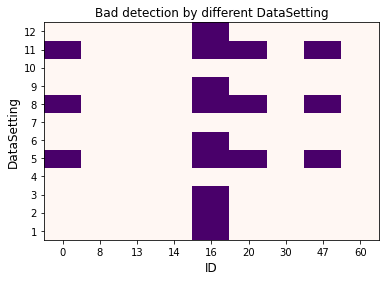


執行時間：6.482305 秒 



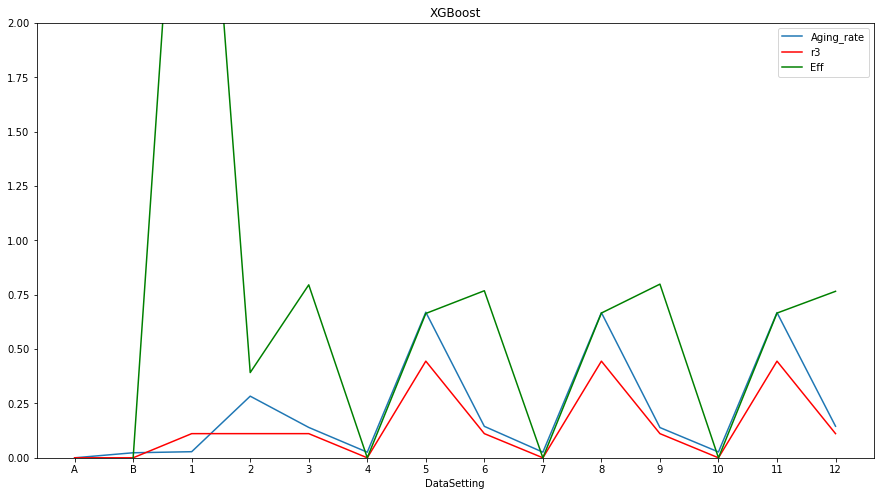

,DataSetting,BR,Train_OK,Train_NG,Filt_OK,p1,r1,p2,r2,p3,r3,Aging_rate,Eff,SRS,0.0,8.0,13.0,14.0,16.0,20.0,30.0,47.0,60.0
DataSettingA,A,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DataSettingB,B,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,0.0232,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0,1,0.3000,1100.0000,330.0000,13436.0000,0.9969,0.9788,0.8522,0.9788,0.0025,0.1111,0.0280,3.9651,0.0041,0.2500,nan,nan,nan,0.7500,0.2500,nan,0.2500,nan
1,2,0.2997,1101.0000,330.0000,13435.0000,0.9970,1.0000,0.0801,1.0000,0.0002,0.1111,0.2835,0.3920,0.2820,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,3,0.3000,1100.0000,330.0000,13436.0000,0.9939,0.9818,0.2295,0.9818,0.0005,0.1111,0.1397,0.7954,0.0808,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,4,0.3002,976.0000,293.0000,13560.0000,1.0000,0.9932,0.9180,0.9932,0.0000,0.0000,0.0258,0.0000,0.0019,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,5,0.3002,976.0000,293.0000,13560.0000,1.0000,0.9932,0.0317,0.9932,0.0004,0.4444,0.6696,0.6638,0.6563,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,6,0.3002,976.0000,293.0000,13560.0000,0.9932,1.0000,0.2136,1.0000,0.0005,0.1111,0.1446,0.7683,0.0794,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,7,0.2952,1118.0000,330.0000,13418.0000,0.9969,0.9788,0.8874,0.9788,0.0000,0.0000,0.0258,0.0000,0.0030,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,8,0.2928,1127.0000,330.0000,13409.0000,1.0000,1.0000,0.0358,1.0000,0.0004,0.4444,0.6676,0.6657,0.6632,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
training(DataSet_A)
p,r=cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=0)
df_A=pd.DataFrame([p,r,ar]).T
df_A.index=['DataSettingA']
df_A.columns=['p3','r3','Aging_rate']

training(DataSet_B)
p,r=cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.6,r=0,infor=0)
df_B=pd.DataFrame([p,r,ar]).T
df_B.index=['DataSettingB']
df_B.columns=['p3','r3','Aging_rate']

start = time.time()
S4_XgBoost(12)
end = time.time()
print("\n執行時間：%f 秒" % (end - start),'\n')

df_PR_new=df_PR_new.drop(columns=['DataSetting'])
DF=pd.concat([df_PR.iloc[:,1:4],df_PR_new.iloc[:,1:]],axis=1)
DF.insert(9,'Aging_rate',df_PR.iloc[:,4:5])
DF=DF.iloc[:,~DF.columns.duplicated()]
DF=pd.concat([DF,df_A,df_B,DF]).iloc[12:]
DF.insert(0,'DataSetting',np.append(['A','B'],np.arange(1,13)))
DF.insert(11,'Eff',(DF.r3)/(DF.Aging_rate))
DF.insert(1,'BR',(DF.Train_NG)/(DF.Train_OK))
pd.set_option('max_columns',None)
Line_Chart(DF,'XGBoost','XGBoost.jpg')
DF.to_csv('XG_0.csv')
display(color(DF))